In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import gym
from continuous_cartpole import ContinuousCartPoleEnv
from tqdm import tqdm_notebook
import numpy as np
from collections import deque
import random
from copy import deepcopy

In [2]:
class QFunction():
    
    def __init__(self, weight_vector):
        self.w = weight_vector
        
    def __call__(self, state, action):
        
        a_pred = μ(state)
        δ = action - a_pred
        
        μ.θ.grad = None
        a_pred.backward()
        ϕ_sa = μ.θ.grad * δ
        Aʷ_sa = mult(ϕ_sa, self.w)
        q_val = Aʷ_sa + V(state)
        
        return q_val

In [3]:
class DeterministicPolicy():
    
    def __init__(self, weight_vector):
        self.θ = weight_vector
        
    def __call__(self, state):
        action = mult(self.θ, state)
        action = torch.tanh(action)
        
        return action

In [4]:
class ValueFunction():
    
    def __init__(self, weight_vector):
        self.v = weight_vector
        
    def __call__(self, state):
        val = mult(self.v, state)
        
        return val

In [5]:
def mult(weight_vector, feature_vector):
    ''' Mulitplies weight vector by feature vector
    Args:
    - weight_vector (Tensor): vector of weights
    - feature_vector (Tensor): vector of features
    
    Return:
    - product (Tensor): product of vectors
    
    '''
    
    #Transpose weight vector and multiply by feature vector
    product = torch.matmul(torch.transpose(weight_vector, 0, 1), feature_vector)
    
    #Return product
    return product

In [6]:
def choose_action(eps, state_tensor):
    action = μ(state_tensor)
    action = torch.tanh(action)
    
    if np.random.random() > eps:
        return action

    return env.action_space.sample()
    

In [7]:
def normalize_state(state, mean, std):
    normalized = (state - mean) / std
    
    return normalized

In [46]:
def update_parameters(item, state_mean, state_std):
    
    state, action, new_state, reward, done = item[0]
    
    state = normalize_state(state, state_mean, state_std)
    new_state = normalize_state(new_state, state_mean, state_std)
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(1)  
    new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(1)
    
    new_action = μ(new_state_tensor)

    δ = reward + γ * Q(new_state_tensor, new_action) - Q(state_tensor, action)

    #calculate θ update
    μ.θ.grad = None
    μ(state_tensor).backward()

    jacob_matrix = μ.θ.grad

    #θ_update = jacob_matrix * mult(jacob_matrix, Q.w) 
    θ_update = Q.w

    #calculate w update
    ϕ_sa = (action - μ(state_tensor)) * jacob_matrix
    w_update = δ.detach() * ϕ_sa.detach()

    #calculate v update
    v_update = δ * jacob_matrix
    #v_update = δ * state_tensor
    
    #update parameters
    μ.θ = μ.θ.detach() + α_θ * θ_update
    μ.θ.requires_grad = True
    
    Q.w = Q.w.detach() + αw * w_update
    V.v = V.v.detach() + αv * v_update

In [35]:
torch.set_printoptions(precision=10)

#discount factor
γ = 0.99

#number of episodes to run
NUM_EPISODES = 100

#max steps per episode
MAX_STEPS = 5000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

α_θ = 0.005
αv = 0.03
αw = 0.03

In [79]:
#Make environment
env = gym.make('MountainCarContinuous-v0').env
env2 = deepcopy(env)

#environment parameters
obs_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

#set seeds
np.random.seed(0)
random.seed(0)
env.seed(0)
torch.manual_seed(0)

#Init weight vectors, should be matrices of dimensions (input, output)
stdv = 1 / np.sqrt(obs_space)
θ = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(obs_space, action_space)) * 0.03)
θ.requires_grad = True
w = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(obs_space, 1)) * 0.03)
v = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(obs_space, 1)) * 0.03)

#Init network
μ = DeterministicPolicy(θ)
Q = QFunction(w)
V = ValueFunction(v)

#samples = np.array(samples)
samples = np.array([env.observation_space.sample() for _ in range(10000)])
state_mean = np.mean(samples, axis = 0)
state_std = np.std(samples, axis= 0) + 1.0e-6

In [80]:
scores = []
policy_scores = []
total_updates = 0

replay_buffer = deque(maxlen=8000)

for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    state = env.reset()
    state2 = env2.reset()
    
    score = 0
    score2 = 0
    
    done = False
    done2 = False
    
    for step in range(MAX_STEPS):        
        action = env.action_space.sample()[0]
        
        new_state, reward, done, _ = env.step([action])

        score += reward
        reward += 100*((np.sin(3*new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (np.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
        
        item = [state, action, new_state, reward, done]
        replay_buffer.append(item)
        
        if step % 10 == 0:
            replay = random.sample(replay_buffer, 1)
            update_parameters(replay, state_mean, state_std)
            total_updates += 1
        
        if total_updates % 3000 == 0:
            if α_θ > 0.005:
                α_θ *= 0.9
            if αw > 0.05:
                αw *= 0.9
            if αv > 0.05:
                αv *= 0.9        
        if done:
            break
        
        state = new_state
    
    scores.append(score)
        
    for step in range(MAX_STEPS):
        #env2.render()
        
        state2 = normalize_state(state2, state_mean, state_std)
        state_tensor2 = torch.from_numpy(state2).float().unsqueeze(1)
        action2 = μ(state_tensor2)
        
        new_state2, reward2, done2, _ = env2.step([action2.item()])
        
        score2 += reward2
        
        if done2:
            break
            
        state2 = new_state2
    
    policy_scores.append(score2)

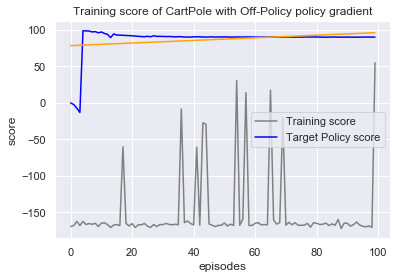

In [81]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores, color='grey', label='Training score')
plt.plot(policy_scores, color='blue', label='Target Policy score')
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Score history of MountainCar with COPDAC-Q')
plt.legend()

reg = LinearRegression().fit(np.arange(len(policy_scores)).reshape(-1, 1), np.array(policy_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(policy_scores)).reshape(-1, 1))
plt.plot(y_pred, color='orange')
plt.show()

In [84]:
scores = []

for _ in tqdm_notebook(range(10)):
    state = env.reset()
    done = False
    score = 0
    for step in range(MAX_STEPS):
        #env.render()
        state = normalize_state(state, state_mean, state_std)
        state_tensor = torch.from_numpy(state).float().unsqueeze(1)
        action = μ(state_tensor)
        new_state, reward, done, info = env.step([action.item()])
        
        score += reward
        
        state = new_state
        
        if done:
            break
    scores.append(score)
env.close()

In [85]:
np.array(scores).mean()

90.30795230000804

In [65]:
np.array(scores).var()

0.0

In [43]:
env.close()